In [2]:
import pandas as pd
import numpy as np

In [7]:
import json

train_data = pd.read_csv("../../results/data/ml/train_data.csv", index_col=0)
test_data = pd.read_csv("../../results/data/ml/test_data.csv", index_col=0)
X_train = train_data.drop("group", axis=1)
y_train = train_data["group"]
X_test = test_data.drop("group", axis=1)
y_test = test_data["group"]

feature_types = json.load(open("../../results/data/ml/feature_types.json"))
glycan_features = feature_types["glycan"]
clinical_features = feature_types["clinical"]

In [8]:
X_train_glycan = X_train[glycan_features]
X_train_clinical = X_train[clinical_features]

<ErrorbarContainer object of 3 artists>

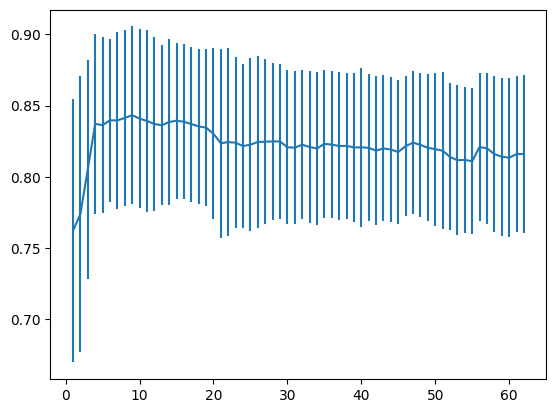

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

score_means = np.empty(len(glycan_features))
score_stds = np.empty(len(glycan_features))

ranks = mrmr_classif(X_train_glycan, y_train, K=len(glycan_features), show_progress=False)

for i in range(len(glycan_features)):
    selected_glycans = ranks[:i+1]
    X_train_subset = X_train[selected_glycans + ["AFP"]]
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    scores = cross_val_score(pipe, X_train_subset, y_train, cv=10, scoring="roc_auc")
    score_means[i] = scores.mean()
    score_stds[i] = scores.std()

plt.errorbar(range(1, len(glycan_features)+1), score_means, yerr=score_stds)

In [5]:
print(ranks[:4])

['H5N4F1', 'H4N4S1', 'H6N5F1S3', 'H3N4F1']


<ErrorbarContainer object of 3 artists>

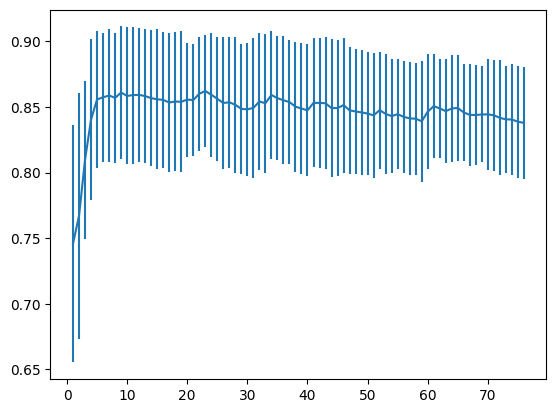

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

n_features = len(X_train.columns)

score_means = np.empty(n_features)
score_stds = np.empty(n_features)

ranks = mrmr_classif(X_train, y_train, K=n_features, show_progress=False)

for i in range(n_features):
    selected_features = ranks[:i+1]
    X_train_subset = X_train[selected_features]
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    scores = cross_val_score(pipe, X_train_subset, y_train, cv=10, scoring="roc_auc")
    score_means[i] = scores.mean()
    score_stds[i] = scores.std()

plt.errorbar(range(1, n_features+1), score_means, yerr=score_stds)

In [6]:
ranks[:10]

['H5N4F1',
 'HBSAG',
 'H6N5F1S3',
 'H3N4F1',
 'CEA',
 'H4N5F1S1',
 'H7N6F1S3',
 'H6N5F2S3',
 'H5N4F1S1',
 'H6N3']

<ErrorbarContainer object of 3 artists>

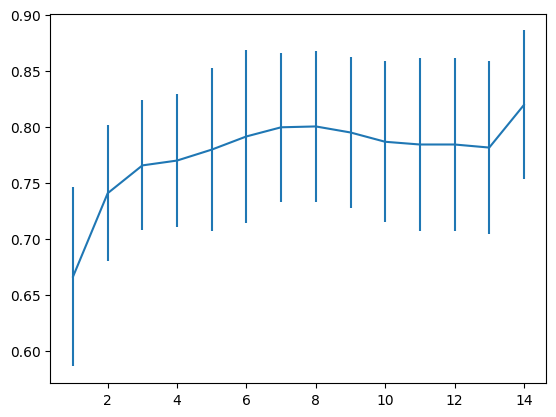

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

n_features = len(clinical_features)

score_means = np.empty(n_features)
score_stds = np.empty(n_features)

ranks = mrmr_classif(X_train_clinical, y_train, K=n_features, show_progress=False)

for i in range(n_features):
    selected_features = ranks[:i+1]
    X_train_subset = X_train[selected_features]
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    scores = cross_val_score(pipe, X_train_subset, y_train, cv=10, scoring="roc_auc")
    score_means[i] = scores.mean()
    score_stds[i] = scores.std()

plt.errorbar(range(1, n_features+1), score_means, yerr=score_stds)

In [12]:
ranks[:8]

['CEA', 'AFP', 'TP', 'HBEAB', 'HBSAG', 'GGT', 'ALT', 'HCV']

In [13]:
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV

final_features = ['H5N4F1', 'H4N4S1', 'H6N5F1S3', 'H3N4F1', 'AFP', 'CEA']
lr = make_pipeline(StandardScaler(), LogisticRegression())
lr = CalibratedClassifierCV(lr, cv=10)
lr.fit(X_train[final_features], y_train)
y_pred = lr.predict(X_test[final_features])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.86      0.84        71
        True       0.81      0.75      0.78        57

    accuracy                           0.81       128
   macro avg       0.81      0.81      0.81       128
weighted avg       0.81      0.81      0.81       128



In [20]:
from sklearn.metrics import roc_auc_score

y_proba = lr.predict_proba(X_test[final_features])[:,1]
roc_auc_score(y_test, y_proba)

0.8492710649864096